In [168]:
include("DiscreteMaps.jl")
using DiscreteMaps, HDF5, JLD, PyPlot, Distributions, Dates
path = "../Dropbox/results/lrb";

In [253]:
module rbpc
using Dates
export RBPContainer
type RBPContainer
#    rundate::DateTime
    PInitial::String
    startstring::String
    M::Integer
    N::Integer
    deps::Float64
    chisq::Array{Float64}
    A0::Array{Float64}
    A1::Array{Float64}
#    epsrange::Array{Float64}
#    eA::Array{Float64}
#    vA::Array{Float64}
end
end
import rbpcontainer
#rundate=DateTime(2015,07,06,10,00,00)
startstring = "rbp"
PInitial = "Lh"
files = DiscreteMaps.searchdirh5(path,["$(startstring)-","-$(PInitial)-"#,replace(string(rundate),":","-")
    ])
RBPv = rbpc.RBPContainer[]
for f in files
    L = load("$(path)/$f")
    N = L["N"]
    M = length(L["epsv"])
    depses = diff(sort(L["epsv"]))
    if maximum(depses) - minimum(depses)>100*eps(maxabs(L["epsv"]))
        error("Parameter (epsilon) values are not equally spaced")
    end
    deps = mean(depses)
    chklr = checklinearresponse(L)
 #   rundate = DateTime(1,1,1,1,1,1)
    PInitial = PInitial
    startstring = startstring
    push!(RBPv,rbpc.RBPContainer(PInitial,startstring,M,N,deps,chklr[1],chklr[3:4]...))
end

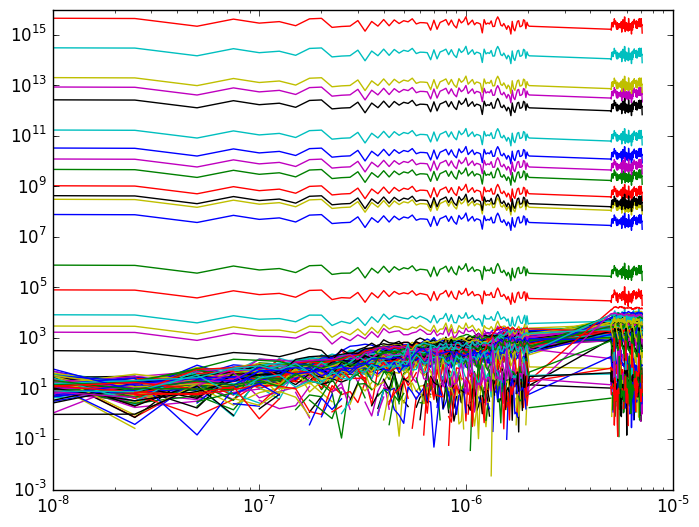

In [256]:
sp = sortperm([RBP.deps for RBP in RBPv])
spt = convert(Array{Bool,1},[(RBP.deps < 1e-5) for RBP in RBPv[sp]]) 
sp = sp[spt]
#sp = sp[(RBP.deps < 1e-6) for RBP in RBPv[sp]]
for i = [1:length(RBPv[1].chisq)]#[DiscreteMaps.sdvs .> 0]
    loglog([RBP.deps for RBP in RBPv][sp],[#maximum
        (RBP.chisq[i])-(RBP.M-2) for RBP in RBPv][sp],"-")
    hold(true)
end
#axis([(10^-8),(10^-4),1.,10^4])


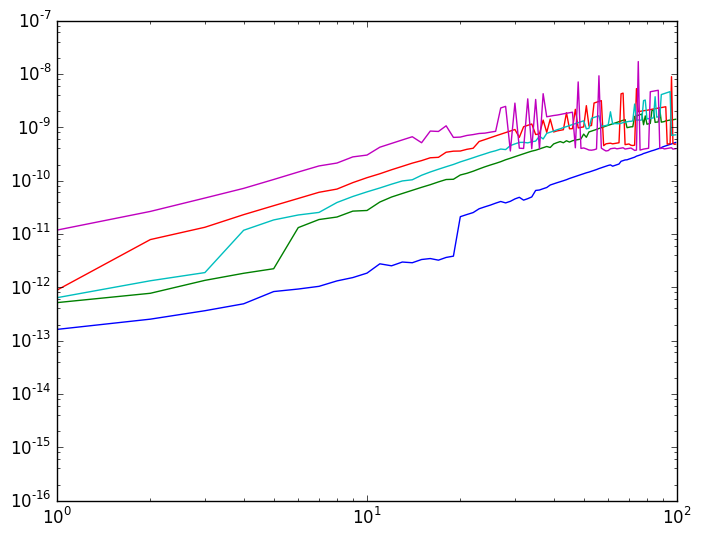

In [257]:
CO = DiscreteMaps.criticalorbit(DiscreteMaps.logistic(3.8),10);
spds = DiscreteMaps.logisticcospeeds(CO,DiscreteMaps.logistic(3.8)) |> abs |> vec;
critpeakwdth = 0.1;
wdths = (CO.mag[:]/critpeakwdth).^2;
p = 3
function sigma(deps::Float64,k::Real,p::Integer,M::Integer=20)
    nepsv = linspace(-1.,1.,M)
    return sum(nepsv * sin(2pi*k*spds[p]*deps*(M-1)/2*nepsv))
end
function tau(deps::Float64,k::Real,p::Integer,M::Integer=20)
    nepsv = linspace(-1.,1.,M)
    return sum(cos(2pi*k*spds[p]*deps*(M-1)/2*nepsv))
end
sinIc(k::Real,x0::Real,p::Integer) = quadgk(x->x^(-1/2)*sin(2pi*k*(x-x0))*DiscreteMaps.testfn(x,0.,wdths[p]),0.,1.)
cosIc(k::Real,x0::Real,p::Integer) = sinIc(k,x0+1/4k,p) # + 1/4k to make cos

#cosIc(k::Real) = quadgk(x^(-1/2)*cos(x)*DiscreteMaps.testfn(x,0.,1.),0.,1.)

function chimax(deps::Float64,k::Real,p::Integer,M::Integer=20)
    nepsv = linspace(-1.,1.,M)
    Xv = [nepsv ones(M)]
    obsv1 = Array(Float64,M)
    obsv2 = Array(Float64,M)
    for i = 1:M
        obsv1[i]= CO.mag[p] * sinIc(k,nepsv[i]*deps*spds[p],p)[1]
        obsv2[i] = CO.mag[p] * cosIc(k,nepsv[i]*deps*spds[p],p)[1]
    end
    IminusH = I - Xv * inv(Xv'*Xv) * Xv'
#    println((norm(IminusH*obsv1),norm(IminusH*obsv2)))
#    return max(norm(IminusH*obsv1),norm(IminusH*obsv2)).^2 # forgetting variance though
#    svdvals(IminusH * [obsv1 obsv2]) |> println
    return svdvals(IminusH * [obsv1 obsv2])[2]
end

for p = 1:5
    loglog([chimax(deps,5.,p) for deps in [1:100]*1e-7])
    hold(true)
end

